In [1]:
import warnings
warnings.filterwarnings('ignore')
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow import keras
from keras.preprocessing.text import  Tokenizer
from keras.preprocessing.sequence import pad_sequences
from Constants import *

In [2]:
data = data_file.copy()

In [3]:
data.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
data.shape

(1600000, 6)

In [5]:
data = data.sample(frac = 1)
data = data[:100000]

In [6]:
data.rename(columns={
                    "polarity" : "Polarity",
                    "text" : "Text"
                    }, inplace = True)

In [7]:
data["Polarity"] = data["Polarity"].replace(4, 1)

In [8]:
num_classes = len(data["Polarity"].unique())
print(data["Polarity"].unique())
print(num_classes)

[1 0]
2


- Polarity Sentiment labels;
- 0 : Negative
- 1 : Positive

In [9]:
data["Text"] = data["Text"].astype('str')

In [10]:
data.drop(["date", "id", "query", "user"], axis = 1, inplace = True)

In [11]:
data.isnull().sum()

Polarity    0
Text        0
dtype: int64

In [12]:
data.iloc[1]

Polarity                                                    0
Text        @deafmom I hate that I'm losing my ASL for lac...
Name: 716670, dtype: object

In [13]:
data[data.columns[:1]]

,Polarity
1252308,1
716670,0
285548,0
1395333,1
594560,0
...,...
238255,0
441127,0
866442,1
58878,0


In [14]:
Positive_tweets = data["Polarity"][data.Polarity == 1]
Negative_tweets = data["Polarity"][data.Polarity == 0]

print("Number of Positive tweets: {}".format(len(Positive_tweets)))
print("Number of Negative tweets: {}".format(len(Negative_tweets)))

Number of Positive tweets: 50174
Number of Negative tweets: 49826


In [15]:
def word_count(words):
    return len(words.split())

In [16]:
text_corpus = []

for line in list(data["Text"]):
    words = line.split()
    for word in words:
        if len(word) > 2:
            text_corpus.append(word.lower())
            
Counter(text_corpus).most_common(10)

[('the', 32240),
 ('and', 18303),
 ('you', 14960),
 ('for', 13389),
 ('have', 9031),
 ('that', 8157),
 ("i'm", 7916),
 ('but', 7763),
 ('just', 7759),
 ('with', 7069)]

In [17]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [18]:
stopword = set(stopwords.words("english"))
print(stopword)

{"won't", 'between', 'but', 'more', "it's", 'ma', 'am', 'while', 'o', 'no', 'this', 'until', 'as', 'now', 'ain', 'these', 'once', "haven't", 'yourself', 'whom', 'further', 'at', "don't", 'because', 'aren', 'shan', 'only', "she's", 'through', 'has', 'been', 'having', 'not', 'its', 'who', 'being', 'under', 'all', 'just', 'do', 'out', 'for', 'about', 'wasn', 'herself', 'isn', 'own', 'to', 'if', 'doing', 'which', "doesn't", 'itself', 'with', 'over', 'nor', 'will', 'hasn', 'what', 'so', 'here', 'won', 'are', 'd', 'when', 'each', 'down', 've', 'couldn', "isn't", 'of', 'or', 'him', 'few', 'm', 'them', 'again', 'their', 'off', 'where', 'hadn', 'during', 'had', 'most', 'himself', 'her', 'in', 't', "shan't", "didn't", 'after', 'a', "couldn't", 'theirs', 'mustn', 'ours', "you'd", "that'll", 'should', 'very', 'did', 'we', 'into', 'hers', 'then', 'don', 'those', 'both', 'can', 'were', 'our', 'weren', "hadn't", "hasn't", 'against', 'was', 'same', 'mightn', 'his', "mustn't", 'before', 'you', 'above',

In [19]:
url_format = r"((http://)[^ ]*(https://)[^ ]*|(www\.)[^ ]*)"
user_format = "@[^\s]+"

In [20]:
def preprocessed_tweets(tweet):
    
    tweet = tweet.lower()
    tweet = tweet[1:]
    
    tweet = re.sub(url_format, "", tweet)
    tweet = re.sub(user_format, "", tweet)
    
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    
    word_tokens = word_tokenize(tweet)
    
    stopword_strip = [w for w in word_tokens if w not in stopword]
    
    word_lemmatize = WordNetLemmatizer()
    base_words = []
    for w in stopword_strip:
        if len(w) > 1:
            word = word_lemmatize.lemmatize(w)
            base_words.append(word)
            
    return ' '.join(base_words)

In [21]:
data["Preprocessed_tweets"] = data["Text"].apply(lambda x : preprocessed_tweets(x))
print("Text Preprocessing Done")

Text Preprocessing Done


In [22]:
data.head()

,Polarity,Text,Preprocessed_tweets
1252308,1,@BradFraser Arctic Monkeys with Josh Homme at ...,bradfraser arctic monkey josh homme helm httpb...
716670,0,@deafmom I hate that I'm losing my ASL for lac...,deafmom hate im losing asl lack practice even ...
285548,0,@ladu Thanks. Just saw 12 name list.No one I k...,ladu thanks saw 12 name listno one know direct...
1395333,1,thank you uninvited guest for shotting down th...,hank uninvited guest shotting party early
594560,0,icing my foot..,cing foot


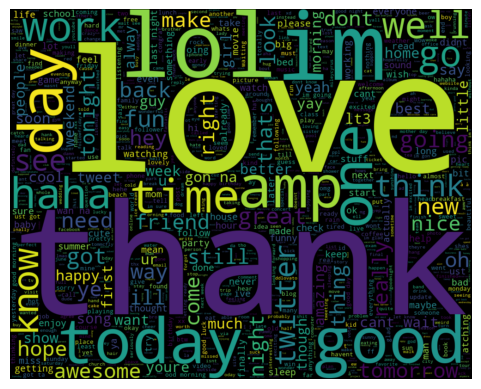

In [23]:
# WordCloud for Positive class

plt.Figure(figsize = (10, 8))
word_cloud = WordCloud(max_words = 1000, width = 1000, height = 800)
word_cloud.generate(" ".join(data[data.Polarity == 1].Preprocessed_tweets))
plt.axis("off")
plt.imshow(word_cloud, interpolation = "bilinear")

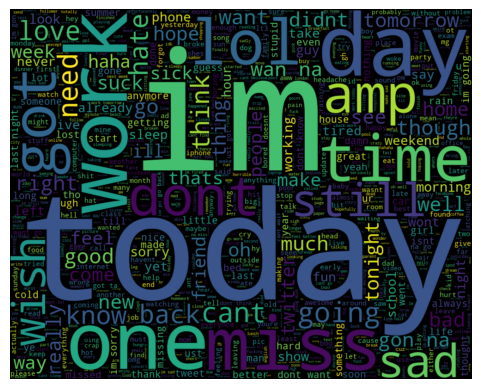

In [24]:
# WordCloud for Negative class

plt.Figure(figsize = (10, 8))
word_cloud = WordCloud(max_words = 1000, width = 1000, height = 800)
word_cloud.generate(" ".join(data[data.Polarity == 0].Preprocessed_tweets))
plt.axis("off")
plt.imshow(word_cloud, interpolation = "bilinear")

In [25]:
X = data["Preprocessed_tweets"].values
y = data[data.columns[:1]].values

In [27]:
vectoriser = TfidfVectorizer(sublinear_tf = True)
X = vectoriser.fit_transform(X)

In [28]:
'''print(vectoriser.get_feature_names()[2])
print(vectoriser.get_feature_names()[200])
print(vectoriser.get_feature_names()[1500])'''

'print(vectoriser.get_feature_names()[2])\nprint(vectoriser.get_feature_names()[200])\nprint(vectoriser.get_feature_names()[1500])'

In [29]:
X_proc = data.Preprocessed_tweets
y_proc = data.Polarity.values

In [30]:
text_tokenizer = Tokenizer(num_words = MAX_FEATURES)
text_tokenizer.fit_on_texts(X_proc)
text_sequence = text_tokenizer.texts_to_sequences(X_proc)
tweets = pad_sequences(text_sequence, maxlen = SEQUENCE_LENGTH)

In [31]:
vectorised_text = tweets
vectorised_text

array([[   0,    0,    0, ...,    0, 2499, 2756],
       [   0,    0,    0, ..., 2012, 3125,  741],
       [   0,    0,    0, ...,   16,   58,   62],
       ...,
       [   0,    0,    0, ..., 1713,  308,   35],
       [   0,    0,    0, ...,  566,   12,   24],
       [   0,    0,    0, ...,   25,  191,   23]])

In [32]:
# The y to be used may differ

dataset = tf.data.Dataset.from_tensor_slices((vectorised_text, y))
dataset = dataset.cache().shuffle(160000).batch(16).prefetch(8)

In [33]:
train_set = dataset.take(int(len(dataset) * 0.7))
val_set = dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset) * 0.2))
test_set = dataset.skip(int(len(dataset) * 0.9)).take(int(len(dataset) * 0.1))

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from keras.preprocessing.text import  Tokenizer
from keras.preprocessing.sequence import pad_sequences
from time import time
from tensorflow.keras.callbacks import TensorBoard

In [35]:
model = keras.Sequential([
    layers.Embedding(MAX_FEATURES + 1, 32),
    layers.Bidirectional(layers.LSTM(32, activation = 'tanh')),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

In [36]:
model.compile(
    optimizer = 'adam',
    loss = 'BinaryCrossentropy',
    metrics = ['accuracy']
)

In [37]:
tensorboard = TensorBoard(log_dir = "logs_3/{}".format(time()))

In [38]:
early_stopping = keras.callbacks.EarlyStopping("val_accuracy",
                               verbose = 1,
                               patience = 3)

In [39]:
history = model.fit(train_set,
                    validation_data = val_set,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    callbacks = [tensorboard, early_stopping],
                    epochs = 15
                    )

Epoch 1/15


4375/4375 [==============================] - 1925s 434ms/step - loss: 0.5262 - accuracy: 0.7336 - val_loss: 0.4616 - val_accuracy: 0.7762
Epoch 2/15
4375/4375 [==============================] - 1878s 429ms/step - loss: 0.4775 - accuracy: 0.7699 - val_loss: 0.4487 - val_accuracy: 0.7906
Epoch 3/15
4375/4375 [==============================] - 1625s 372ms/step - loss: 0.4546 - accuracy: 0.7846 - val_loss: 0.4190 - val_accuracy: 0.8028
Epoch 4/15
4375/4375 [==============================] - 1623s 371ms/step - loss: 0.4378 - accuracy: 0.7922 - val_loss: 0.4002 - val_accuracy: 0.8202
Epoch 5/15
4375/4375 [==============================] - 1664s 380ms/step - loss: 0.4204 - accuracy: 0.8045 - val_loss: 0.3879 - val_accuracy: 0.8233
Epoch 6/15
4375/4375 [==============================] - 1620s 370ms/step - loss: 0.4054 - accuracy: 0.8118 - val_loss: 0.3635 - val_accuracy: 0.8332
Epoch 7/15
4375/4375 [==============================] - 1600s 366ms/step - loss: 0.3827 - accuracy: 0.82

In [40]:
model.evaluate(test_set)

625/625 [==============================] - 54s 85ms/step - loss: 0.2128 - accuracy: 0.9098


[0.2127506136894226, 0.9097999930381775]

In [41]:
history = history.history

In [42]:
val_loss = history['val_loss']
loss = history['loss']

val_accuracy = history["val_accuracy"]
accuracy = history["accuracy"]

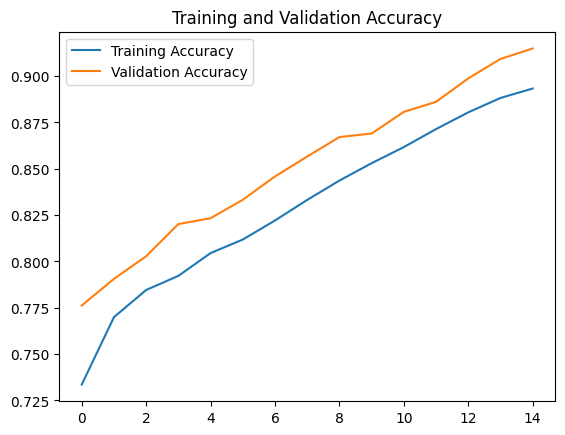

In [43]:
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'upper left')
plt.title("Training and Validation Accuracy")
plt.show()

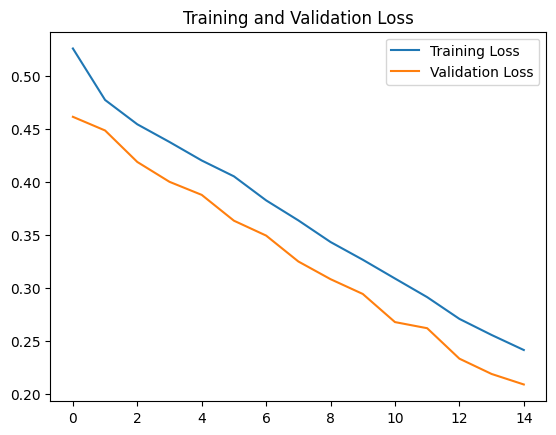

In [44]:
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [45]:
model.save("tweets_3.h5")

In [46]:
model = tf.keras.models.load_model("tweets_3.h5")

In [47]:
import pickle

file = open("vectoriser_2.pickle", "wb")
pickle.dump(vectoriser, file)
file.close()

In [ ]:
# Resource exhausted, run in kaggle

# how to use saved tf model to make prediction on and output in a dataframe with feature and label

# how to use saved tf nlp model to make prediction on sentence array and output in a dataframe with feature and label

In [ ]:
# For creating df for new predictions

'''# Load the saved TensorFlow model
model = tf.keras.models.load_model('saved_model_path')

# Prepare new data
new_data = pd.DataFrame({
    'feature1': [1, 2, 3],
    'feature2': ['a', 'b', 'c']
})

# Make predictions
predictions = model.predict(new_data)

# Create DataFrame with features and labels
features = new_data.copy()
labels = predictions

predictions_df = pd.DataFrame(data={'features': features, 'labels': labels})

print(predictions_df)'''